In [4]:
import os
import xarray as xr
import cfgrib
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# NARR
### Filter to Surface Level

In [36]:
ds = xr.open_dataset('../data/narr-a_221_19790108_0000_000.grb',engine='cfgrib',filter_by_keys={'stepType':'instant','typeOfLevel': 'surface'},backend_kwargs={'errors': 'ignore'})
print(ds)

Ignoring index file '../data/narr-a_221_19790108_0000_000.grb.5b7b6.idx' incompatible with GRIB file


<xarray.Dataset> Size: 4MB
Dimensions:     (y: 277, x: 349)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 773kB ...
    longitude   (y, x) float64 773kB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    talm2       (y, x) float32 387kB ...
    t2ag2       (y, x) float32 387kB ...
    tprl1       (y, x) float32 387kB ...
    tprg3       (y, x) float32 387kB ...
    tpg200      (y, x) float32 387kB ...
    tpg80       (y, x) float32 387kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          15
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-25T17:09 GRIB to CDM+CF via cfgrib-0.9.1...


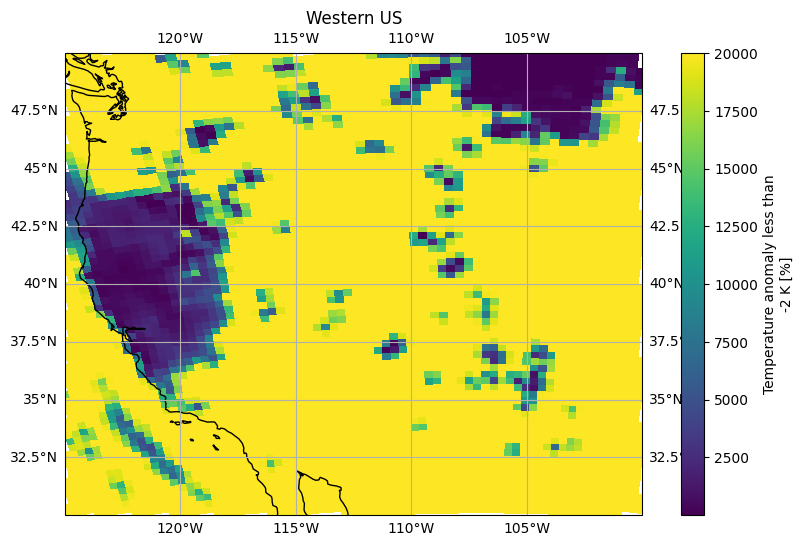

In [40]:
lat_min, lat_max = 30, 50  # Latitude range for Western U.S.
lon_min, lon_max = 235, 260 # Longitude range for Western U.S.

ds_west_us = ds.where(
    (ds['latitude'] >= lat_min) & (ds['latitude'] <= lat_max) &
    (ds['longitude'] >= lon_min) & (ds['longitude'] <= lon_max),
    drop=True
)

data = ds_west_us['talm2']
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data with the Lambert Conformal projection
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), x='longitude', y='latitude')

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title("Western US")
plt.show()

### Filter by Isobaric Pressure 

In [45]:
ds = xr.open_dataset('../data/narr-a_221_19790108_0000_000.grb',engine='cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
print(ds)

Ignoring index file '../data/narr-a_221_19790108_0000_000.grb.5b7b6.idx' incompatible with GRIB file


<xarray.Dataset> Size: 24MB
Dimensions:        (isobaricInhPa: 29, y: 277, x: 349)
Coordinates:
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 232B 1e+03 975.0 ... 125.0 100.0
    latitude       (y, x) float64 773kB ...
    longitude      (y, x) float64 773kB ...
    valid_time     datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    tpag10         (isobaricInhPa, y, x) float32 11MB ...
    unknown        (isobaricInhPa, y, x) float32 11MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          15
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-25T17:20 GRIB to CDM+CF via cfgrib-0.9.1...


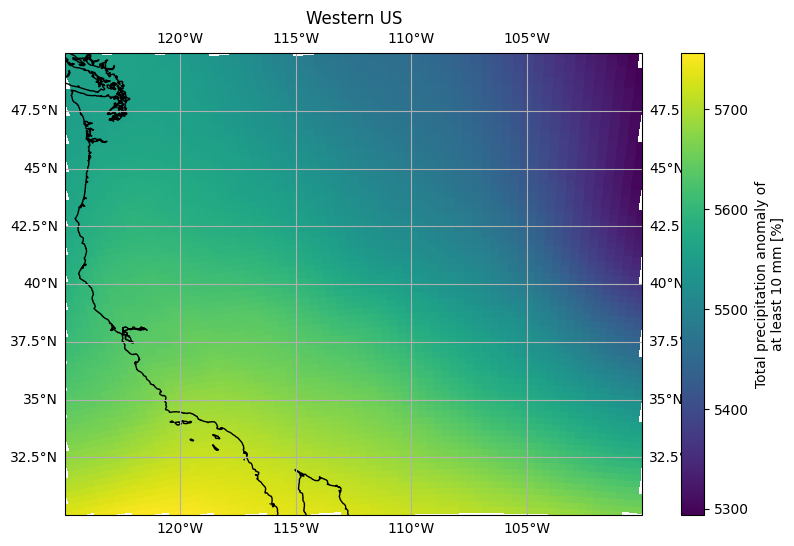

In [53]:
data = ds_west_us['tpag10'].sel(isobaricInhPa=500)

# Create the figure and axis using the Lambert Conformal projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data using Lambert Conformal projection
data.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), x='longitude', y='latitude')

# Set the geographic extent of the Western U.S. (use PlateCarree for this)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# Set the title and show the plot
plt.title("Western US")
plt.show()

In [48]:
print(data.dims)
print(data.coords)

('isobaricInhPa', 'y', 'x')
Coordinates:
    time           datetime64[ns] 8B 1979-01-08
    step           timedelta64[ns] 8B 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 232B 1e+03 975.0 ... 125.0 100.0
    latitude       (y, x) float64 46kB 28.43 28.49 28.55 ... 50.82 50.78 50.75
    longitude      (y, x) float64 46kB 235.6 235.9 236.2 ... 262.1 262.5 263.0
    valid_time     datetime64[ns] 8B 1979-01-08


# GWIS: GlobFire

In [ ]:
#Combining all the years into one .shp; this will take about 5 minutes to run

western_us_bounds = {
    "min_longitude": -125,
    "max_longitude": -100,
    "min_latitude": 32,
    "max_latitude": 49
}

main = gpd.read_file('../data/globfire/original_globfire_filtered_2002.shp').to_crs(epsg=4326).cx[
    western_us_bounds["min_longitude"]:western_us_bounds["max_longitude"],
    western_us_bounds["min_latitude"]:western_us_bounds["max_latitude"]]

for year in np.arange(2003,2024):
    print(year)
    temp = gpd.read_file(f"../data/globfire/original_globfire_filtered_{year}.shp")
    temp = temp.to_crs(epsg=4326).cx[
        western_us_bounds["min_longitude"]:western_us_bounds["max_longitude"],
        western_us_bounds["min_latitude"]:western_us_bounds["max_latitude"]]
    main = pd.concat([main,temp])

main.to_file("../data/full_globfire.shp")

(32.0, 49.0)

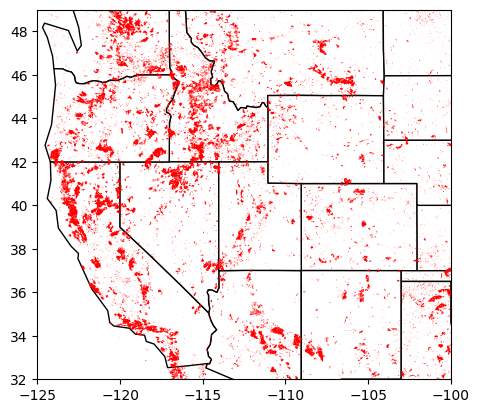

In [13]:
states = gpd.read_file('../data/state_borders/ne_110m_admin_1_states_provinces.shp')

ax = states.plot(color='white', edgecolor='black')

main.plot(ax=ax,color="red",markersize = main["area_ha"]/np.max(main["area_ha"]))
ax.set_xlim([-125,-100])
ax.set_ylim([32,49])